In [1]:
import torch
from torchtext import data,datasets
import random
import torch.nn as nn
from torch import optim
import numpy as np
import time
import copy

**Step 1 : Instantiate Text and Label field**

In [2]:
SEED = 4

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
#create text field to store textdata
#tokenize text data with "spacy" tokenizer
TEXT = data.Field(tokenize = 'spacy',include_lengths = True)
#create label field to store labels in float
LABEL = data.LabelField(dtype = torch.float)

**Step 2 : Create data split**

In [3]:
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
print(type(train_data))
print(len(train_data))
print(len(test_data))

aclImdb_v1.tar.gz:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:02<00:00, 37.1MB/s]


<class 'torchtext.datasets.imdb.IMDB'>
25000
25000


In [4]:
#create train and validation split from train data
train_data, valid_data = train_data.split(random_state = random.seed(SEED))
#check size of splits
print(len(train_data))
print(len(valid_data))
print(len(test_data))

17500
7500
25000


**Step 3 : Build vocabulary from training data**

In [5]:
MAX_VOCAB_SIZE = 10000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

print("Vocabulary size : ",len(TEXT.vocab))
print("No of different labels : ",len(LABEL.vocab))

.vector_cache/glove.6B.zip: 862MB [06:28, 2.22MB/s]                           
100%|█████████▉| 399341/400000 [00:22<00:00, 17328.18it/s]

Vocabulary size :  10002
No of different labels :  2


In [10]:
#print most 20 frequently occured tokens in the corpus
print(TEXT.vocab.freqs.most_common(20))

[('the', 203653), (',', 192410), ('.', 165777), ('and', 109844), ('a', 109404), ('of', 100996), ('to', 94003), ('is', 76197), ('in', 61428), ('I', 54258), ('it', 53583), ('that', 49228), ('"', 43922), ("'s", 43359), ('this', 42349), ('-', 36831), ('/><br', 35639), ('was', 35187), ('as', 30351), ('with', 29982)]


In [11]:
print(TEXT.vocab.itos[:10])
print(LABEL.vocab.stoi)

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']
defaultdict(<function _default_unk_index at 0x7ff467d17158>, {'neg': 0, 'pos': 1})


**Step 4 : Create dataloader**

In [12]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

trainloader, valloader, testloader = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

**Step 5 : Build model**

In [45]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.lstm=nn.LSTM(embedding_dim, 
                           hidden_dim[0], 
                           num_layers=1, 
                           bidirectional=True, 
                           )
        self.lstm2=nn.LSTM(hidden_dim[0]*2, 
                           hidden_dim[1], 
                           num_layers=1, 
                           bidirectional=True, 
                           )
        
        self.fc = nn.Linear(hidden_dim[1]*2, 16)
        self.fc2=nn.Linear(16,output_dim)
    def forward(self, text,text_lengths):

        #text = [sent len, batch size]
        #print(text.shape)
        embedded = self.embedding(text)
        #print(embedded.shape)
        #embedded = [sent len, batch size, emb dim]
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        #print(packed_embedded)
        output, (hidden,cell) = self.lstm(packed_embedded)
        #print("lstm1---output :",output.shape,"---hidden :",hidden.shape,"---cell :",cell.shape)
        output, (hidden,cell) = self.lstm2(output)
        #print("lstm2---output :",output.shape,"---hidden :",hidden.shape,"---cell :",cell.shape)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(output)
        #print("unpacked seq :",output.shape)
        hidden=torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        #assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        ans=self.fc(hidden)
        ans=self.fc2(ans)
        return ans

**Step 5 : Instanstiate Loss function, Optimizer, Model**

In [46]:
VOCAB_SIZE = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = [32,64]
OUTPUT_DIM = 2
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

In [47]:
def evaluation_gpu(preds, y):
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.FloatTensor([y.shape[0]])

In [48]:
def fit_gpu(trainloader,valloader,model,opt,loss_fn,epochs=25):
        #callback=StopatLossValue()
        time0=time.time()
        trainloss=[]
        valloss=[]
        trainacclist=[]
        valacclist=[]
        min_valloss=10000000.0000000
        min_trainloss=10000000.0000000
        max_valacc=0.0
        max_trainacc=0.0
        
        for epoch in range(epochs):
            runningtrain_loss=0
            runningval_loss=0
            #init_fn()
            for i, data in enumerate(trainloader, 0):

                #inputs, labels = data
                #inputs=inputs.to(device)
                #labels=labels.to(device)

                #forward pass
                text, text_lengths = data.text
                predtrain=model(text,text_lengths)
                label=data.label.long()
                loss = loss_fn(predtrain,label)
                trainacc=evaluation_gpu(predtrain,data.label)
                #backward and optimize
                opt.zero_grad()
                loss.backward()
                opt.step()
                
                
                runningtrain_loss += loss.item()
            #init_fn()
            for i, data in enumerate(valloader,0):
                #inputs, labels = data
                #inputs=inputs.to(device)
                #labels=labels.to(device)

                #forward pass
                text, text_lengths = data.text
                predval=model(text,text_lengths)
                label=data.label.long()
                loss = loss_fn(predval, label)
                valacc=evaluation_gpu(predval,data.label)

                runningval_loss += loss.item()
            avgval_loss=runningval_loss/len(valloader)
            avgtrain_loss=runningtrain_loss/len(trainloader)
            if (avgval_loss<min_valloss):
                min_valloss=avgval_loss    
                vallossmodel=copy.deepcopy(model.state_dict())
            if (avgtrain_loss<min_trainloss):
                min_trainloss=avgtrain_loss
                trainlossmodel=copy.deepcopy(model.state_dict())
            trainacclist.append(trainacc)
            valacclist.append(valacc)
            if (trainacc>max_trainacc):
                max_trainacc=trainacc
                trainaccmodel=copy.deepcopy(model.state_dict())
            if (valacc>max_valacc):
                max_trainacc=valacc
                valaccmodel=copy.deepcopy(model.state_dict())      
            print("Minimum training Loss :",min_trainloss,"| Minimum validation Loss :",min_valloss) 
            print("Epoch {} - Training loss: {}".format(epoch,avgtrain_loss ),"| validation loss: {}".format(avgval_loss))    
            print('Epoch: %d/%d, Train acc: %0.2f' % (epoch, epochs-1,trainacc ),'| val acc: %0.2f' % (valacc))
            print('------------------------------------------------------------------------------------------')
            trainloss.append(avgtrain_loss)       
            valloss.append(avgval_loss)
            #vis.line(Y=avgtrain_loss, opts=dict(showlegend=True))
        print("Training Time(in minutes) =",(time.time()-time0)/60)    
        return vallossmodel,trainlossmodel,valaccmodel,trainaccmodel,trainloss,valloss,trainacclist,valacclist

In [49]:
model = RNN(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM,PAD_IDX)
model = model.to(device)

In [50]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)
model.embedding.weight.data.copy_(pretrained_embeddings)



UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

torch.Size([10002, 100])
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.4976, -0.4068,  0.4789,  ..., -0.7738, -0.2583, -0.4652],
        [-0.9215,  0.6813, -0.0406,  ..., -0.2463, -0.0135,  0.7864],
        [ 0.3809,  0.5248,  0.6496,  ...,  0.2828, -0.3464,  0.2937]],
       device='cuda:0')


In [51]:
opt = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()
vallossmodel,trainlossmodel,valaccmodel,trainaccmodel,trainloss,valloss,trainacclist,valacclist=fit_gpu(trainloader,valloader,model,opt,loss_fn)

Minimum training Loss : 0.5787809820781025 | Minimum validation Loss : 0.4724230701619006
Epoch 0 - Training loss: 0.5787809820781025 | validation loss: 0.4724230701619006
Epoch: 0/24, Train acc: 0.81 | val acc: 0.83
------------------------------------------------------------------------------------------
Minimum training Loss : 0.3833010581064922 | Minimum validation Loss : 0.3705816372911981
Epoch 1 - Training loss: 0.3833010581064922 | validation loss: 0.3705816372911981
Epoch: 1/24, Train acc: 0.81 | val acc: 0.75
------------------------------------------------------------------------------------------
Minimum training Loss : 0.2668467818110691 | Minimum validation Loss : 0.3373976056880139
Epoch 2 - Training loss: 0.2668467818110691 | validation loss: 0.3373976056880139
Epoch: 2/24, Train acc: 0.81 | val acc: 0.83
------------------------------------------------------------------------------------------
Minimum training Loss : 0.19304754999100182 | Minimum validation Loss : 0.33

In [54]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
            text,text_lenghts=batch.text
            predictions = model(text,text_lenghts)
            label=batch.label.long()
            loss = criterion(predictions, label)
            
            acc = evaluation_gpu(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)



In [55]:
model.load_state_dict(valaccmodel)
test_loss, test_acc = evaluate(model, testloader, loss_fn)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.914 | Test Acc: 84.92%


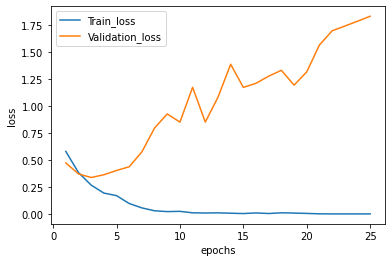

In [56]:
import matplotlib.pyplot as plt

epochs=len(trainloss)
plt.plot([i for i in range(1,epochs+1)],trainloss,label="Train_loss")
plt.plot([i for i in range(1,epochs+1)],valloss,label="Validation_loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

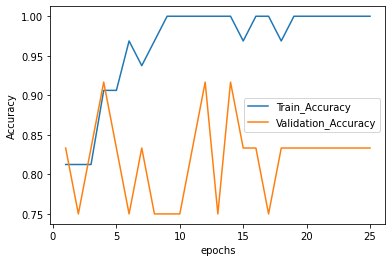

In [57]:
plt.plot([i for i in range(1,epochs+1)],trainacclist,label="Train_Accuracy")
plt.plot([i for i in range(1,epochs+1)],valacclist,label="Validation_Accuracy")
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()